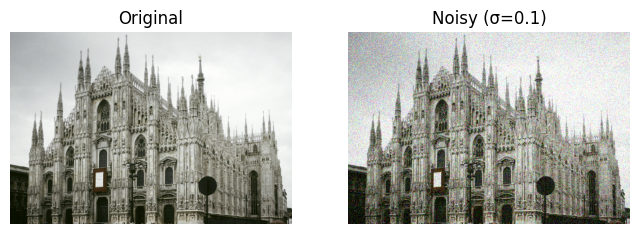

In [1]:
# Colab cell 1 — load image and add noise
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
np.random.seed(0)

img=Image.open('image.jpg').convert('RGB')
img=np.array(img).astype(np.float32)/255.0  #float image in [0,1]

# adding Gaussian noise
sigma_noise=0.1
noisy_image=img+np.random.normal(0,sigma_noise,img.shape).astype(np.float32)
noisy_image=np.clip(noisy_image,0.0,1.0)

plt.figure(figsize=(8,4))
plt.subplot(1,2,1);plt.imshow(img);plt.title('Original');plt.axis('off')
plt.subplot(1,2,2);plt.imshow(noisy_image);plt.title('Noisy (σ={})'.format(sigma_noise));plt.axis('off')
plt.show()


#Bilateral Filtering Implementation

PSNR noisy: 20.616 dB
PSNR filtered: 25.182 dB


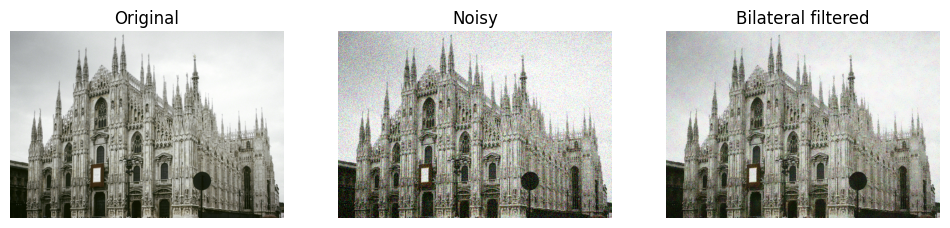

In [2]:
import math
def psnr(a, b):
    #calculates peak-signal to noise ratio= 20log10. (max/rootMSE)
    mse=np.mean((a-b)**2)
    return 20*math.log10(1.0/math.sqrt(mse)) if mse>0 else 100.0

def bilateral_filter(img, kernel_radius=3, sigma_s=3.0, sigma_r=0.1):
    H,W,C=img.shape
    out=np.zeros_like(img)
    kr=kernel_radius
    # precompute spatial gaussian
    ax=np.arange(-kr, kr+1)
    xx,yy=np.meshgrid(ax, ax)
    spatial=np.exp(-(xx**2 + yy**2)/(2*(sigma_s**2)))

    #pad image
    pad=kr
    padded=np.pad(img, ((pad,pad),(pad,pad),(0,0)), mode='reflect')

    for y in range(H):
        for x in range(W):
            yc,xc=y+pad,x+pad
            window=padded[yc-kr:yc+kr+1, xc-kr:xc+kr+1, :]
            center=padded[yc,xc,:][None,None,:]
            #computes color (range) gaussian using L2 color distance
            diff=window-center
            color_dist2=np.sum(diff*diff,axis=2)  # sum over channels
            range_w = np.exp(- color_dist2 / (2 * (sigma_r**2)))
            weights = spatial * range_w  # elementwise
            Wsum = np.sum(weights)
            # weighted sum over channels
            val = np.sum(window * weights[:, :, None], axis=(0,1)) / (Wsum + 1e-12)
            out[y, x, :] = val
    return out

kernel_radius=5
sigma_s=5.0
sigma_r=0.12

# run bilateral filter on noisy image
filtered=bilateral_filter(noisy_image, kernel_radius=kernel_radius, sigma_s=sigma_s, sigma_r=sigma_r)

# print PSNRs and show results
print("PSNR noisy:", round(psnr(img, noisy_image), 3), "dB")
print("PSNR filtered:", round(psnr(img, filtered), 3), "dB")

plt.figure(figsize=(12,4))
plt.subplot(1,3,1); plt.imshow(img); plt.title('Original'); plt.axis('off')
plt.subplot(1,3,2); plt.imshow(noisy_image); plt.title('Noisy'); plt.axis('off')
plt.subplot(1,3,3); plt.imshow(np.clip(filtered,0,1)); plt.title('Bilateral filtered'); plt.axis('off')
plt.show()


#Guided Filtering Implementation

PSNR noisy vs original: 26.311 dB
PSNR filtered vs original: 28.189 dB


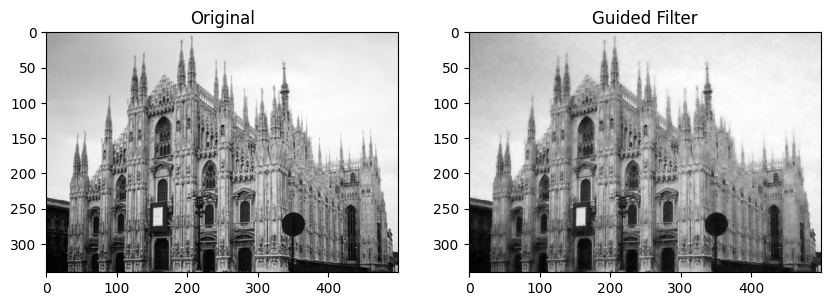

In [3]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
def psnr(a, b):
    mse = np.mean((a - b) ** 2)
    return 20 * math.log10(1.0 / math.sqrt(mse)) if mse > 0 else 100.0
#I Original Image
#Ig guided image
def guidedfilter(I, Ig, w=3, eps=1e-3):
    I = I.astype(np.float32)
    Ig = Ig.astype(np.float32)
    h, W = I.shape
    padding = w

    #giving padding for filter
    Ipadding=cv2.copyMakeBorder(I, padding, padding, padding, padding, cv2.BORDER_REFLECT)
    Igpadding=cv2.copyMakeBorder(Ig, padding, padding, padding, padding, cv2.BORDER_REFLECT)
    output=np.zeros_like(I)
    for i in range(h):
        for j in range(W):
            s=i+padding
            t=j+padding

            windowIg=Igpadding[s-w:s+w+1,t-w:t+w+1]
            windowI=Ipadding[s-w:s+w+1,t-w:t+w+1]

            # mean and variance of guidance image
            muk=np.mean(windowIg)
            vark=np.var(windowIg)

            # neighbouring weight compute
            differences=Igpadding[s, t]-muk
            differencet=windowIg-muk
            wst=1+(differences*differencet)/(vark + eps)

            # Normalize weights
            wst=wst/np.sum(wst)

            # Filtered value
            output[i, j] = np.sum(wst * windowI)
    return np.clip(output, 0, 1)
img = cv2.imread('image.jpg')
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) / 255.0
noisy = np.clip(gray + np.random.normal(0, 0.05, gray.shape), 0, 1)
guided = guidedfilter(noisy, noisy, w=3, eps=0.01)
print("PSNR noisy vs original:", round(psnr(gray, noisy), 3), "dB")
print("PSNR filtered vs original:", round(psnr(gray, guided), 3), "dB")
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.imshow(gray, cmap='gray')
plt.title("Original")

plt.subplot(1,2,2)
plt.imshow(guided, cmap='gray')
plt.title("Guided Filter")

plt.show()


#Geodesic Filtering Implementation

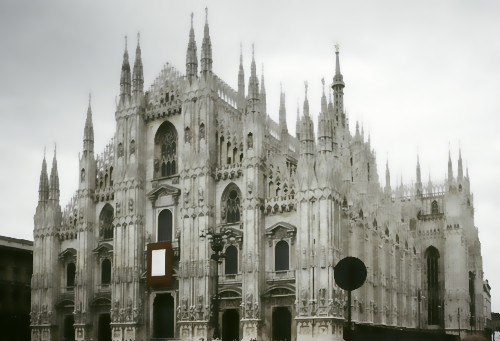

In [4]:
import cv2
import numpy as np
from google.colab.patches import cv2_imshow

def geodesic_filter(img, guidance, radius=5, sigma_color=30, sigma_space=3):
    # Convert to float for computation
    img = img.astype(np.float32)
    guidance = guidance.astype(np.float32)

    # Pad for boundary
    pad = radius
    padded = cv2.copyMakeBorder(img, pad, pad, pad, pad, cv2.BORDER_REFLECT)
    guide_padded = cv2.copyMakeBorder(guidance, pad, pad, pad, pad, cv2.BORDER_REFLECT)

    h, w, _ = img.shape
    filtered = np.zeros_like(img)

    # Precompute spatial Gaussian
    y, x = np.mgrid[-radius:radius+1, -radius:radius+1]
    spatial_weight = np.exp(-(x**2 + y**2) / (2 * sigma_space**2))

    # Iterate over pixels
    for i in range(h):
        for j in range(w):
            # Extract local patch
            patch = padded[i:i+2*radius+1, j:j+2*radius+1]
            guide_patch = guide_padded[i:i+2*radius+1, j:j+2*radius+1]
            center = guide_padded[i+radius, j+radius]

            # Compute color distance (Euclidean)
            color_diff = guide_patch - center
            color_dist = np.sqrt(np.sum(color_diff ** 2, axis=2))

            # Geodesic approximation: combines color + spatial distance
            color_weight = np.exp(-(color_dist**2) / (2 * sigma_color**2))
            weight = spatial_weight * color_weight

            # Normalize weights
            weight_sum = np.sum(weight)
            if weight_sum != 0:
                weight = weight / weight_sum

            # Weighted sum for each color channel
            for c in range(3):
                filtered[i, j, c] = np.sum(patch[:, :, c] * weight)

    return np.clip(filtered, 0, 255).astype(np.uint8)


# ---- Usage Example ----
img = cv2.imread("image.jpg")
filtered = geodesic_filter(img, img, radius=5, sigma_color=50, sigma_space=3)
cv2_imshow(filtered)


#Propagation Filter Implementation

In [5]:
import math
from tqdm import tqdm

def psnr(a, b):
    mse = np.mean((a - b) ** 2)
    return 20 * math.log10(1.0 / math.sqrt(mse)) if mse > 0 else 100.0

def propagation_filter(img, w=3, sigma=0.1):
    H, W, C = img.shape
    out = np.zeros_like(img)
    pad = w
    padded = np.pad(img, ((pad,pad),(pad,pad),(0,0)), mode='reflect')

    # predefine Gaussian for photometric relation
    def G(delta):  # Gaussian based on intensity difference
        return np.exp(- (delta**2) / (2 * sigma**2))

    # Propagation in 4 directions (simplified 2D path pattern)
    for y in tqdm(range(H), desc="rows"):
        for x in range(W):
            yc, xc = y + pad, x + pad
            center = padded[yc, xc, :]
            ws_sum = np.zeros((2*w+1, 2*w+1))
            num_sum = np.zeros(3)

            # iterate through neighborhood
            for dy in range(-w, w+1):
                for dx in range(-w, w+1):
                    ny, nx = yc + dy, xc + dx
                    neighbor = padded[ny, nx, :]

                    # propagate relationship: along path, weight reduces
                    diff_center = np.linalg.norm(center - neighbor)
                    # adjacent-pixel factor: between neighbor and its previous step
                    prev = padded[ny - np.sign(dy), nx - np.sign(dx), :]
                    diff_adj = np.linalg.norm(prev - neighbor)

                    # combine both as in eq (7) using Gaussian D and R
                    D = G(diff_adj)
                    R = G(diff_center)
                    weight = D * R
                    ws_sum[dy+w, dx+w] = weight
                    num_sum += neighbor * weight

            Z = np.sum(ws_sum)
            out[y, x, :] = num_sum / (Z + 1e-8)
    return out



#Experiments

#IMAGE DENOISING

PSNR (Noisy):        20.741 dB
PSNR (Bilateral):    27.225 dB
PSNR (Guided):       25.262 dB
PSNR (Propagation):  26.35 dB
PSNR (Geodesic):     27.037 dB


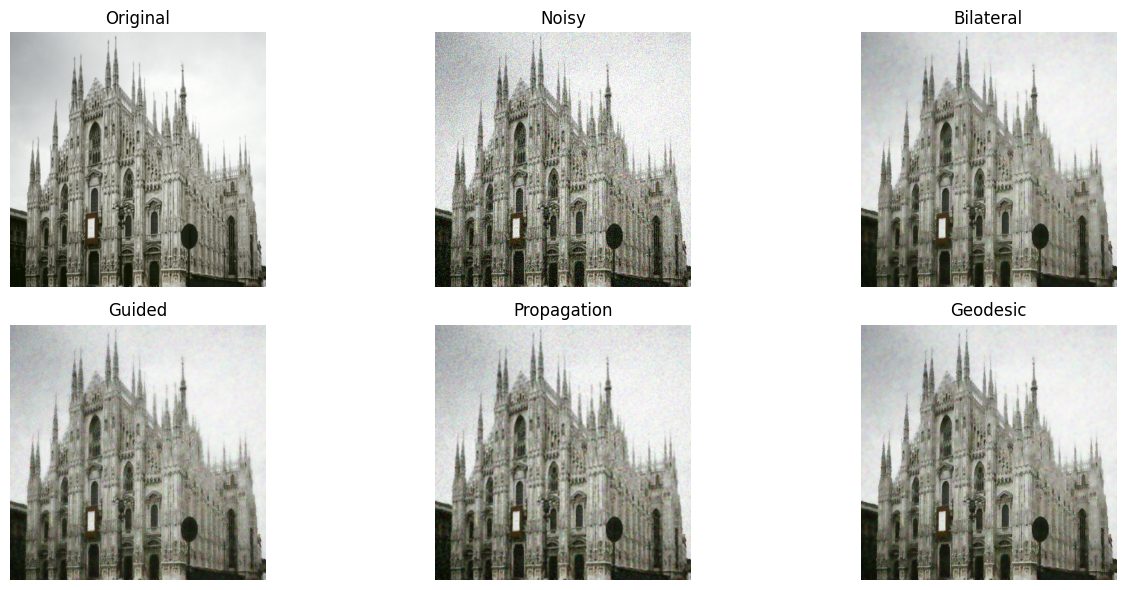

In [6]:
#Compare all 4 filters for IMAGE DENOISING
import cv2, numpy as np, math, matplotlib.pyplot as plt

#PSNR function
def psnr(a, b):
    a = a.astype(np.float32) / 255.0
    b = b.astype(np.float32) / 255.0
    mse = np.mean((a - b) ** 2)
    return 20 * math.log10(1.0 / math.sqrt(mse)) if mse > 0 else 100.0

#Guided filter (simple implementation)
def guidedfilter_color(I, p, r, eps):
    I = I.astype(np.float32)
    p = p.astype(np.float32)
    h, w, c = I.shape

    # Mean of I and p in the local window
    mean_I = cv2.boxFilter(I, -1, (r, r))
    mean_p = cv2.boxFilter(p, -1, (r, r))

    # Cross and auto correlations
    mean_II = cv2.boxFilter(I * I, -1, (r, r))
    mean_Ip = cv2.boxFilter(I * p, -1, (r, r))

    cov_Ip = mean_Ip - mean_I * mean_p
    var_I = mean_II - mean_I * mean_I + eps

    # Compute coefficients a and b for each channel
    a = cov_Ip / var_I
    b = mean_p - a * mean_I

    mean_a = cv2.boxFilter(a, -1, (r, r))
    mean_b = cv2.boxFilter(b, -1, (r, r))

    q = mean_a * I + mean_b
    return np.clip(q, 0, 1)
# Propagation filter (simplified version)
def propagation_filter(img, w=3, sigma=0.3):
    pad = w // 2
    padded = np.pad(img, ((pad, pad), (pad, pad), (0, 0)), mode='reflect')
    h, W, c = img.shape
    out = np.zeros_like(img)
    for i in range(h):
        for j in range(W):
            region = padded[i:i+w, j:j+w]
            diff = region - padded[i+pad, j+pad]
            weights = np.exp(-(diff**2).sum(axis=2) / (2 * sigma**2))
            weights /= np.sum(weights)
            out[i, j] = np.sum(region * weights[:, :, None], axis=(0,1))
    return np.clip(out, 0, 1)

def geodesic_filter(img, guidance, radius=3, sigma_color=0.2, sigma_space=3):
    img = img.astype(np.float32) / 255.0
    guide = guidance.astype(np.float32) / 255.0
    h, w, c = img.shape
    out = np.zeros_like(img)
    pad = radius
    padded = np.pad(img, ((pad,pad),(pad,pad),(0,0)), mode='reflect')
    gpad = np.pad(guide, ((pad,pad),(pad,pad),(0,0)), mode='reflect')
    # precompute spatial weights
    y, x = np.mgrid[-pad:pad+1, -pad:pad+1]
    spatial_w = np.exp(-(x**2 + y**2) / (2*sigma_space**2))
    for i in range(h):
        for j in range(w):
            region = padded[i:i+2*pad+1, j:j+2*pad+1]
            gregion = gpad[i:i+2*pad+1, j:j+2*pad+1]
            dist_color = np.sum((gregion - gpad[i+pad,j+pad])**2, axis=2)
            color_w = np.exp(-dist_color / (2 * sigma_color**2))
            weight = color_w * spatial_w
            weight /= np.sum(weight)
            out[i,j] = np.sum(region * weight[:,:,None], axis=(0,1))
    return np.clip(out*255, 0, 255).astype(np.uint8)

#Load and add Gaussian noise (instead of blur)
img = cv2.imread('image.jpg')
img = cv2.resize(img, (400, 400))

# Add Gaussian noise
mean, sigma = 0, 25
noise = np.random.normal(mean, sigma, img.shape).astype(np.float32)
noisy = np.clip(img.astype(np.float32) + noise, 0, 255).astype(np.uint8)

#Apply filters for denoising
bilat = cv2.bilateralFilter(noisy, d=9, sigmaColor=75, sigmaSpace=75)
guided_gray = cv2.cvtColor(noisy, cv2.COLOR_BGR2GRAY) / 255.0
# Guided filter for color (denoising)
guided = guidedfilter_color(noisy / 255.0, noisy / 255.0, r=5, eps=0.02)
guided = np.clip(guided * 255, 0, 255).astype(np.uint8)
prop   = (propagation_filter(noisy.astype(np.float32)/255.0, w=3, sigma=0.4) * 255).astype(np.uint8)
geo    = geodesic_filter(noisy, noisy, radius=3, sigma_color=0.2, sigma_space=3)

#Compute PSNRs
print("PSNR (Noisy):       ", round(psnr(img, noisy),3), "dB")
print("PSNR (Bilateral):   ", round(psnr(img, bilat),3), "dB")
print("PSNR (Guided):      ", round(psnr(img, guided),3), "dB")
print("PSNR (Propagation): ", round(psnr(img, prop),3), "dB")
print("PSNR (Geodesic):    ", round(psnr(img, geo),3), "dB")

#Visualize
plt.figure(figsize=(14,6))
plt.subplot(2,3,1); plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB)); plt.title('Original'); plt.axis('off')
plt.subplot(2,3,2); plt.imshow(cv2.cvtColor(noisy, cv2.COLOR_BGR2RGB)); plt.title('Noisy'); plt.axis('off')
plt.subplot(2,3,3); plt.imshow(cv2.cvtColor(bilat, cv2.COLOR_BGR2RGB)); plt.title('Bilateral'); plt.axis('off')
plt.subplot(2,3,4); plt.imshow(cv2.cvtColor(guided, cv2.COLOR_BGR2RGB)); plt.title('Guided'); plt.axis('off')
plt.subplot(2,3,5); plt.imshow(cv2.cvtColor(prop, cv2.COLOR_BGR2RGB)); plt.title('Propagation'); plt.axis('off')
plt.subplot(2,3,6); plt.imshow(cv2.cvtColor(geo, cv2.COLOR_BGR2RGB)); plt.title('Geodesic'); plt.axis('off')
plt.tight_layout(); plt.show()


#Image Smoothening

PSNR (Bilateral): 26.046 dB
PSNR (Guided): 20.144 dB
PSNR (Propagation): 26.868 dB
PSNR (Geodesic): 24.421 dB


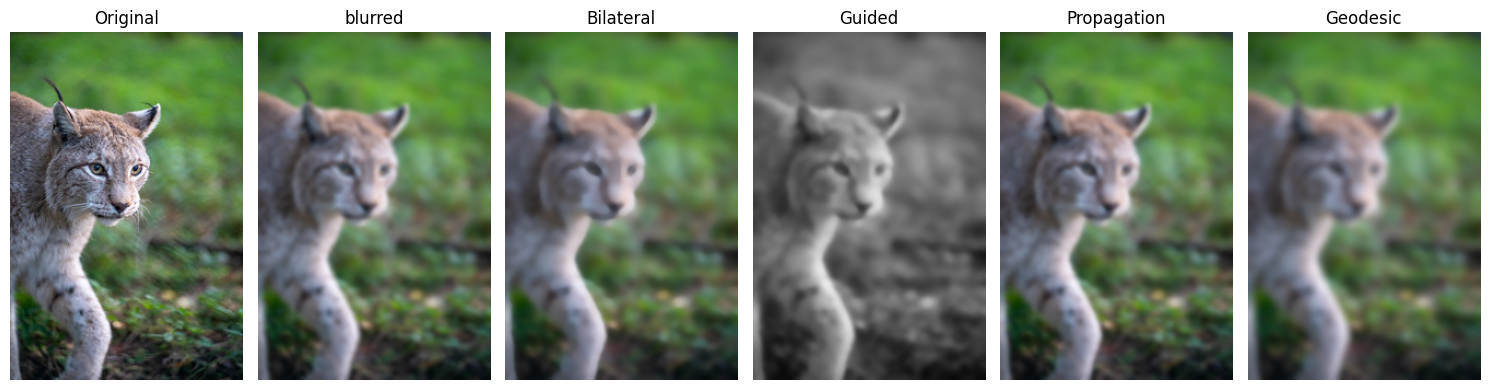

In [7]:
import cv2, numpy as np, math, matplotlib.pyplot as plt

def psnr(a, b):
    a = a.astype(np.float32) / 255.0
    b = b.astype(np.float32) / 255.0
    mse = np.mean((a - b) ** 2)
    return 20 * math.log10(1.0 / math.sqrt(mse)) if mse > 0 else 100.0

# load and blur
img = cv2.imread('image_smoothening.jpg')
blurred = cv2.GaussianBlur(img, (9,9), 2)

# run filters (adapt each to color input)
bilat = cv2.bilateralFilter(blurred, d=9, sigmaColor=75, sigmaSpace=75)
#bilat=bilateral_filter(blurred, kernel_radius=5, sigma_s=75, sigma_r=0.29)
guided_gray = cv2.cvtColor(blurred, cv2.COLOR_BGR2GRAY) / 255.0
guided = (guidedfilter(guided_gray, guided_gray, w=3, eps=0.01) * 255).astype(np.uint8)
guided = cv2.cvtColor(guided, cv2.COLOR_GRAY2BGR)
prop   = (propagation_filter(blurred.astype(np.float32)/255.0, w=3, sigma=0.1) * 255).astype(np.uint8)
geo    = geodesic_filter(blurred, blurred, radius=5, sigma_color=50, sigma_space=3)

# compute PSNRs
print("PSNR (Bilateral):",   round(psnr(img, bilat),3), "dB")
print("PSNR (Guided):",      round(psnr(img, guided),3), "dB")
print("PSNR (Propagation):", round(psnr(img, prop),3), "dB")
print("PSNR (Geodesic):",    round(psnr(img, geo),3), "dB")

# visualize
plt.figure(figsize=(15,5))
plt.subplot(1,6,1); plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB)); plt.title('Original'); plt.axis('off')
plt.subplot(1,6,2); plt.imshow(cv2.cvtColor(blurred, cv2.COLOR_BGR2RGB)); plt.title('blurred'); plt.axis('off')
plt.subplot(1,6,3); plt.imshow(cv2.cvtColor(bilat, cv2.COLOR_BGR2RGB)); plt.title('Bilateral'); plt.axis('off')
plt.subplot(1,6,4); plt.imshow(cv2.cvtColor(guided, cv2.COLOR_BGR2RGB)); plt.title('Guided'); plt.axis('off')
plt.subplot(1,6,5); plt.imshow(cv2.cvtColor(prop, cv2.COLOR_BGR2RGB)); plt.title('Propagation'); plt.axis('off')
plt.subplot(1,6,6); plt.imshow(cv2.cvtColor(geo, cv2.COLOR_BGR2RGB)); plt.title('Geodesic'); plt.axis('off')
plt.tight_layout(); plt.show()


#Flash/No Flash Denoising

PSNR (Noisy): 24.767 dB
PSNR (Bilateral): 31.455 dB
PSNR (Guided): 17.17 dB
PSNR (Propagation): 29.698 dB
PSNR (Geodesic): 28.472 dB


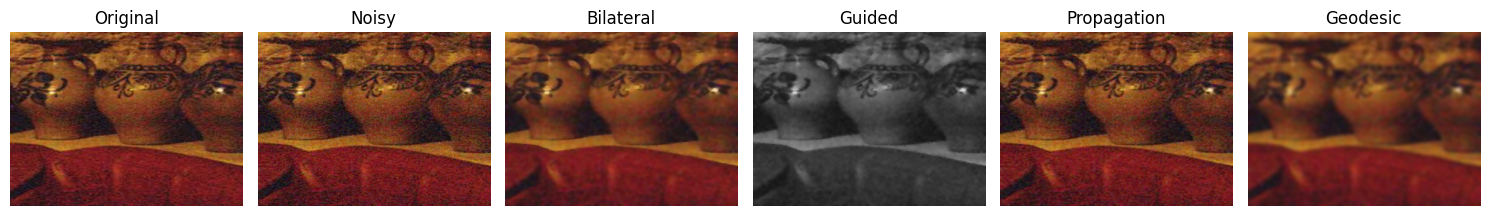

In [9]:
# === Flash/No-Flash Denoising Comparison ===
import cv2, numpy as np, math, matplotlib.pyplot as plt

def psnr(a, b):
    a = a.astype(np.float32) / 255.0
    b = b.astype(np.float32) / 255.0
    mse = np.mean((a - b) ** 2)
    return 20 * math.log10(1.0 / math.sqrt(mse)) if mse > 0 else 100.0

# load no-flash image
img_nf = cv2.imread('no_flash_image.jpg')
img_nf = cv2.resize(img_nf, (400, 300))
# add Gaussian noise
sigma_noise = 15
noisy = np.clip(img_nf + np.random.normal(0, sigma_noise, img_nf.shape), 0, 255).astype(np.uint8)

# run filters
bilat = cv2.bilateralFilter(noisy, d=9, sigmaColor=75, sigmaSpace=75)
guided_gray = cv2.cvtColor(noisy, cv2.COLOR_BGR2GRAY) / 255.0
guided = (guidedfilter(guided_gray, guided_gray, w=3, eps=0.01) * 255).astype(np.uint8)
guided = cv2.cvtColor(guided, cv2.COLOR_GRAY2BGR)
prop= (propagation_filter(noisy.astype(np.float32)/255.0, w=3, sigma=0.1) * 255).astype(np.uint8)
geo= geodesic_filter(noisy, noisy, radius=5, sigma_color=50, sigma_space=3)

# compute PSNRs
print("PSNR (Noisy):", round(psnr(img_nf, noisy),3),"dB")
print("PSNR (Bilateral):",   round(psnr(img_nf, bilat),3),"dB")
print("PSNR (Guided):",      round(psnr(img_nf, guided),3),"dB")
print("PSNR (Propagation):", round(psnr(img_nf, prop),3),"dB")
print("PSNR (Geodesic):",    round(psnr(img_nf, geo),3),"dB")

# visualize all
plt.figure(figsize=(15,5))
plt.subplot(1,6,1); plt.imshow(cv2.cvtColor(img_nf, cv2.COLOR_BGR2RGB)); plt.title('Original'); plt.axis('off')
plt.subplot(1,6,2); plt.imshow(cv2.cvtColor(noisy, cv2.COLOR_BGR2RGB)); plt.title('Noisy'); plt.axis('off')
plt.subplot(1,6,3); plt.imshow(cv2.cvtColor(bilat, cv2.COLOR_BGR2RGB)); plt.title('Bilateral'); plt.axis('off')
plt.subplot(1,6,4); plt.imshow(cv2.cvtColor(guided, cv2.COLOR_BGR2RGB)); plt.title('Guided'); plt.axis('off')
plt.subplot(1,6,5); plt.imshow(cv2.cvtColor(prop, cv2.COLOR_BGR2RGB)); plt.title('Propagation'); plt.axis('off')
plt.subplot(1,6,6); plt.imshow(cv2.cvtColor(geo, cv2.COLOR_BGR2RGB)); plt.title('Geodesic'); plt.axis('off')
plt.tight_layout(); plt.show()


#Image Fusion

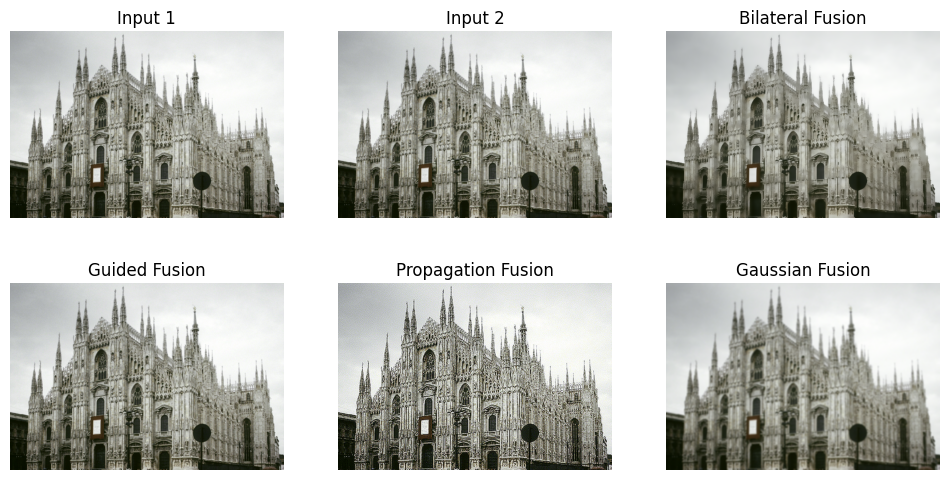


PSNR Comparison:
Bilateral    : 30.806623221641512
Guided       : 51.79096904011991
Propagation  : 17.748997593258874


In [10]:
import cv2
import numpy as np
import math
import matplotlib.pyplot as plt

# -------- PSNR METRIC --------
def fusion_psnr(img1, img2):
    img1 = img1.astype(np.float32) / 255.0
    img2 = img2.astype(np.float32) / 255.0
    mse = np.mean((img1 - img2) ** 2)
    return 20 * math.log10(1.0 / math.sqrt(mse)) if mse > 0 else 100

# -------- 1) BILATERAL FILTER --------
def fuse_bilateral(img):
    return cv2.bilateralFilter(img, 9, 75, 75)

# -------- 2) GUIDED FILTER --------
def fuse_guided(I, p, r=16, eps=1e-3):
    mean_I = cv2.boxFilter(I, cv2.CV_64F, (r,r))
    mean_p = cv2.boxFilter(p, cv2.CV_64F, (r,r))
    corr_I = cv2.boxFilter(I*I, cv2.CV_64F, (r,r))
    corr_Ip = cv2.boxFilter(I*p, cv2.CV_64F, (r,r))

    var_I = corr_I - mean_I * mean_I
    cov_Ip = corr_Ip - mean_I * mean_p

    a = cov_Ip / (var_I + eps)
    b = mean_p - a * mean_I

    mean_a = cv2.boxFilter(a, cv2.CV_64F, (r,r))
    mean_b = cv2.boxFilter(b, cv2.CV_64F, (r,r))

    q = mean_a * I + mean_b
    return q

# -------- 3) SIMPLE PROPAGATION FILTER (EDGE-AWARE DIFFUSION APPROX) --------
def fuse_propagation(img, guidance=None, iters=3, alpha=0.2):
    if guidance is None:
        guidance = img.copy().astype(np.float32)

    img = img.astype(np.float32)
    for _ in range(iters):
        # Use ddepth=-1 to match the input image's depth and channel count
        lap = cv2.Laplacian(img, -1)
        guidance_gray = cv2.cvtColor(guidance.astype(np.uint8), cv2.COLOR_BGR2GRAY)
        edge = cv2.Canny(guidance_gray, 40, 120)
        edge = edge / 255.0
        edge = np.expand_dims(edge, axis=-1) # Expand to (H, W, 1)
        img = img - alpha * lap * (1 - edge)
    return img

# -------- 4) GAUSSIAN FILTER (baseline) --------
def fuse_gaussian(img):
    return cv2.GaussianBlur(img, (5,5), 1.2)

# -------- MULTI FOCUS WEIGHT MAP (Laplacian saliency) --------
def weight_map(img):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    lap = cv2.Laplacian(gray, cv2.CV_32F)
    return cv2.GaussianBlur(np.abs(lap), (5,5), 2)

# -------- FUSION FUNCTION --------
def fuse_images(imgA, imgB, mode="bilateral"):
    W1 = weight_map(imgA)
    W2 = weight_map(imgB)

    # normalize weights
    W_sum = W1 + W2 + 1e-12
    wA = W1 / W_sum
    wB = W2 / W_sum

    if mode=="bilateral":
        imgA = fuse_bilateral(imgA)
        imgB = fuse_bilateral(imgB)
    elif mode=="guided":
        imgA = fuse_guided(imgA, imgA)
        imgB = fuse_guided(imgB, imgB)
    elif mode=="propagation":
        imgA = fuse_propagation(imgA, imgA)
        imgB = fuse_propagation(imgB, imgB)
    elif mode=="gaussian":
        imgA = fuse_gaussian(imgA)
        imgB = fuse_gaussian(imgB)

    fused = imgA * wA[:,:,None] + imgB * wB[:,:,None]
    return np.clip(fused,0,255).astype(np.uint8)

# ------------- LOAD MULTI-FOCUS INPUTS -------------
img1 = cv2.imread("image.jpg")
img2 = cv2.imread("image.jpg")

# ------------- FUSE USING ALL 4 FILTERS -------------
fused_bf  = fuse_images(img1, img2, "bilateral")
fused_gf  = fuse_images(img1, img2, "guided")
fused_pf  = fuse_images(img1, img2, "propagation")
fused_gau = fuse_images(img1, img2, "gaussian")

# ------------- SHOW RESULTS -------------
titles = ["Input 1","Input 2","Bilateral Fusion","Guided Fusion","Propagation Fusion","Gaussian Fusion"]
imgs   = [img1, img2, fused_bf, fused_gf, fused_pf, fused_gau]

plt.figure(figsize=(12,6))
for i in range(6):
    plt.subplot(2,3,i+1)
    plt.imshow(cv2.cvtColor(imgs[i], cv2.COLOR_BGR2RGB))
    plt.title(titles[i]); plt.axis("off")
plt.show()

# ------------- PSNR COMPARISON -------------
print("\nPSNR Comparison:")
print("Bilateral    :", fusion_psnr(img1, fused_bf))
print("Guided       :", fusion_psnr(img1, fused_gf))
print("Propagation  :", fusion_psnr(img1, fused_pf))